In [133]:
import pandas as pd
import sqlite3


def getSlotsFromDB(city: str, concern: str | None):

    conn = sqlite3.connect(f"db/{city}.db")

    sql = """
    SELECT 
        Availabilities.slot_id as s_id,
        Slots.office as office,
        Slots.city as city,
        Slots.timeslot as timeslot,
        Slots.concern as concern,
        Availabilities.id as a_id,
        Availabilities.available as available,
        Availabilities.taken as taken
    FROM Slots
    JOIN Availabilities ON Slots.id = Availabilities.slot_id;
    """

    df = pd.read_sql_query(sql, conn, parse_dates=["available", "taken", "timeslot"])

    conn.close()

    if concern:
        df = df[df["concern"] == concern]

    return df


df = getSlotsFromDB("duesseldorf", "Personalausweis - Antrag")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42451 entries, 499 to 170804
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   s_id       42451 non-null  int64         
 1   office     42451 non-null  object        
 2   city       42451 non-null  object        
 3   timeslot   42451 non-null  datetime64[ns]
 4   concern    42451 non-null  object        
 5   a_id       42451 non-null  int64         
 6   available  42451 non-null  datetime64[ns]
 7   taken      41143 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(3)
memory usage: 2.9+ MB


In [134]:
# lose precision to only minutes
df["timeslot"] = df["timeslot"].dt.floor("min")
df["available"] = df["available"].dt.floor("min")
df["taken"] = df["taken"].dt.floor("min")

# timdelta between available and taken
df["delta"] = df["taken"] - df["available"]


# # convert to string
# open_slots_over_time["timeslot"] = open_slots_over_time["timeslot"].dt.strftime("%a %d.%m. %H:%M")
# open_slots_over_time["available"] = open_slots_over_time["available"].dt.strftime("%a %d.%m. %H:%M")
# open_slots_over_time["taken"] = open_slots_over_time["taken"].dt.strftime("%a %d.%m. %H:%M")

df

,s_id,office,city,timeslot,concern,a_id,available,taken,delta
499,500,Benrath,Duesseldorf,2024-10-28 12:40:00,Personalausweis - Antrag,500,2024-10-27 14:01:00,2024-10-27 14:09:00,0 days 00:08:00
500,501,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:15:00,Personalausweis - Antrag,501,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
501,502,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:20:00,Personalausweis - Antrag,502,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
502,503,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:25:00,Personalausweis - Antrag,503,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
503,504,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:30:00,Personalausweis - Antrag,504,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
...,...,...,...,...,...,...,...,...,...
170800,52043,Benrath,Duesseldorf,2024-11-07 14:00:00,Personalausweis - Antrag,170801,2024-11-07 09:57:00,NaT,NaT
170801,52047,Benrath,Duesseldorf,2024-11-07 14:20:00,Personalausweis - Antrag,170802,2024-11-07 09:57:00,NaT,NaT
170802,54141,Gerresheim,Duesseldorf,2024-11-07 16:40:00,Personalausweis - Antrag,170803,2024-11-07 09:57:00,NaT,NaT
170803,14528,Dienstleistungszentrum,Duesseldorf,2024-11-07 11:05:00,Personalausweis - Antrag,170804,2024-11-07 09:57:00,NaT,NaT


<Axes: title={'center': 'Open slots over time'}, xlabel='Time', ylabel='Open slots'>

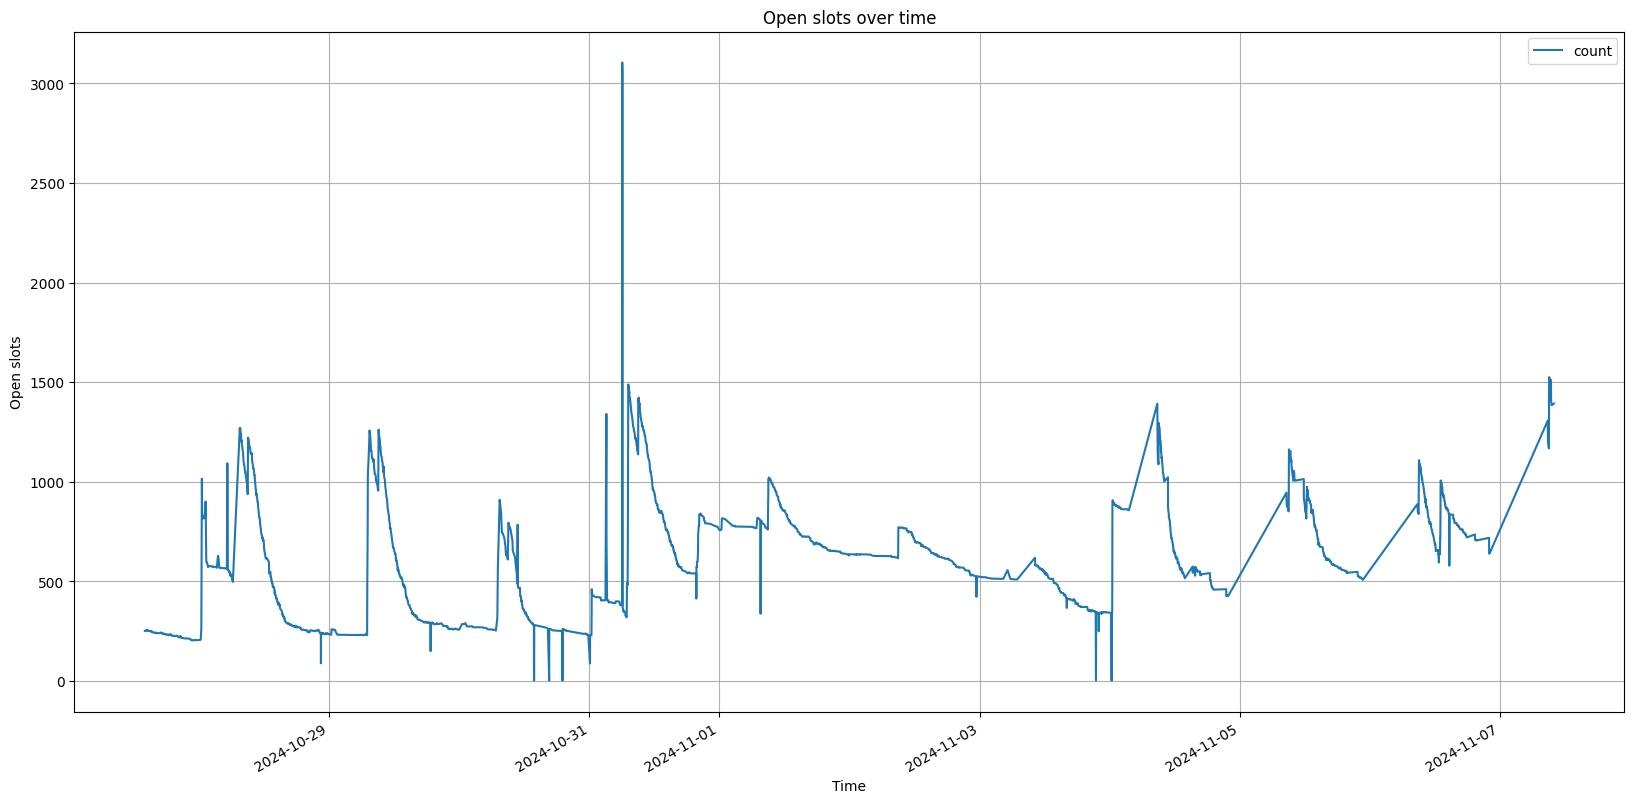

In [135]:
# get all unique timestamps from available and taken
timestamps = pd.concat([df["available"], df["taken"]]).sort_values().unique()
timestamps

count = pd.Series(dtype=int)
for timestamp in timestamps:
    
    # count slots for each timestamp
    count_per_timestamp = df[
        (df["available"] <= timestamp) & ((df["taken"] >= timestamp) | (df["taken"].isnull()))
    ].shape[0]

    count.at[timestamp] = count_per_timestamp

count_df = pd.DataFrame({"timestamp": timestamps, "count": count})

count_df.plot(x="timestamp", y="count", kind="line",figsize=(20,10), grid=True, title="Open slots over time", xlabel="Time", ylabel="Open slots")


In [180]:
time_until_slot = df.groupby(by="available").agg({"timeslot": ["min","max"]})

time_until_slot["time_until_slot"] = time_until_slot["timeslot"]["min"] - time_until_slot.index

time_until_slot

timeslot                      time_until_slot
                                    min                 max                 
available                                                                   
2024-10-27 14:01:00 2024-10-28 12:40:00 2024-11-15 12:45:00  0 days 22:39:00
2024-10-27 14:08:00 2024-11-11 10:35:00 2024-11-12 09:10:00 14 days 20:27:00
2024-10-27 14:21:00 2024-11-11 08:45:00 2024-11-15 12:45:00 14 days 18:24:00
2024-10-27 14:27:00 2024-11-11 08:45:00 2024-11-11 08:45:00 14 days 18:18:00
2024-10-27 14:28:00 2024-10-28 14:30:00 2024-10-28 14:35:00  1 days 00:02:00
...                                 ...                 ...              ...
2024-11-07 09:22:00 2024-11-07 10:55:00 2024-11-21 14:45:00  0 days 01:33:00
2024-11-07 09:24:00 2024-11-07 10:15:00 2024-11-21 10:15:00  0 days 00:51:00
2024-11-07 09:26:00 2024-11-12 12:40:00 2024-11-12 12:40:00  5 days 03:14:00
2024-11-07 09:30:00 2024-11-07 10:50:00 2024-11-07 11:05:00  0 days 01:20:00
2024-11-07 09:57:00 2024-11-07 10:05:00 2024-11-21 14:40:00  0 days 00:08:00

[1500 rows x 3 columns]

<Axes: title={'center': 'Time until slot'}, xlabel='Time', ylabel='Hours until slot'>

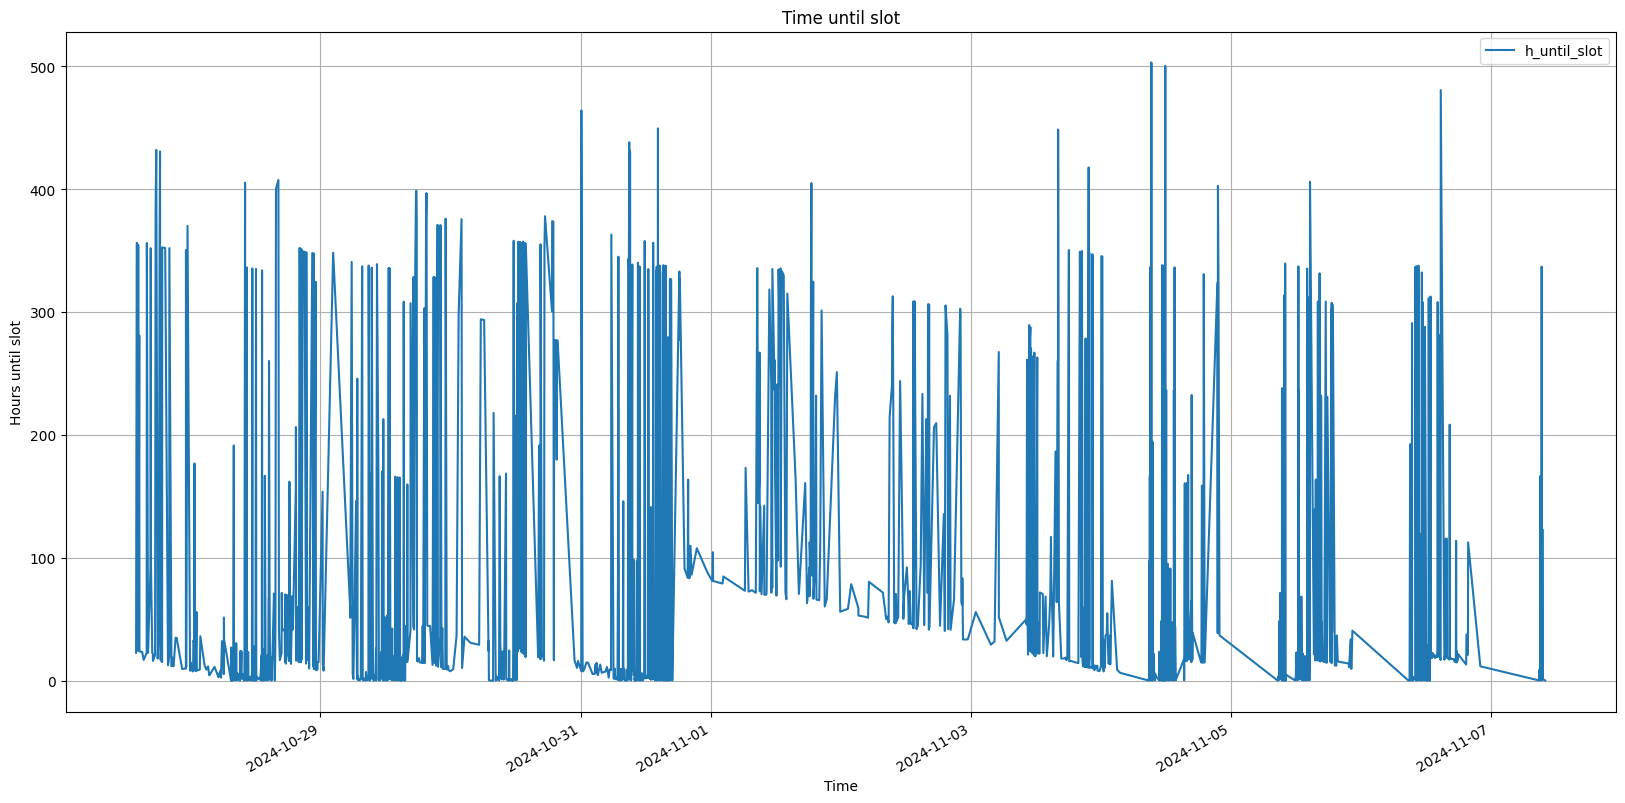

In [201]:
# convert to hours
time_until_slot["h_until_slot"] = time_until_slot["time_until_slot"].dt.total_seconds() / 3600
time_until_slot["days_until_slot"] = time_until_slot["time_until_slot"].dt.days

time_until_slot.plot(y="h_until_slot", kind="line",figsize=(20,10), grid=True, title="Time until slot", xlabel="Time", ylabel="Hours until slot")

In [202]:
# # der als nächstes verfügbare Termin über die Zeit
timestamp = timestamps[0]
df[
    (df["available"] == timestamp) | ((df["taken"] == timestamp))
]["timeslot"].sort_values()

#     if pd.isna(next_available_timestamp):
#         time_to_next_available.append(pd.NaT)
#     else:
#         time_to_next_available.append(next_available_timestamp - timestamp)

# time_to_next_available_df = pd.DataFrame({"timestamp": timestamps, "time_to_next_available": time_to_next_available})

# time_to_next_available_df.plot(x="timestamp", y="time_to_next_available", kind="line", figsize=(20,10), grid=True, title="Time to next available slot over time", xlabel="Time", ylabel="Time to next available slot")

499   2024-10-28 12:40:00
500   2024-11-11 11:15:00
501   2024-11-11 11:20:00
502   2024-11-11 11:25:00
503   2024-11-11 11:30:00
              ...        
744   2024-11-15 12:25:00
745   2024-11-15 12:30:00
746   2024-11-15 12:35:00
747   2024-11-15 12:40:00
748   2024-11-15 12:45:00
Name: timeslot, Length: 250, dtype: datetime64[ns]

In [203]:
# save day of the week
df["day"] = df["timeslot"].dt.day_name()
df["hour"] = df["timeslot"].dt.hour

df

,s_id,office,city,timeslot,concern,a_id,available,taken,delta,day,hour
499,500,Benrath,Duesseldorf,2024-10-28 12:40:00,Personalausweis - Antrag,500,2024-10-27 14:01:00,2024-10-27 14:09:00,0 days 00:08:00,Monday,12
500,501,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:15:00,Personalausweis - Antrag,501,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00,Monday,11
501,502,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:20:00,Personalausweis - Antrag,502,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00,Monday,11
502,503,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:25:00,Personalausweis - Antrag,503,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00,Monday,11
503,504,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:30:00,Personalausweis - Antrag,504,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00,Monday,11
...,...,...,...,...,...,...,...,...,...,...,...
170800,52043,Benrath,Duesseldorf,2024-11-07 14:00:00,Personalausweis - Antrag,170801,2024-11-07 09:57:00,NaT,NaT,Thursday,14
170801,52047,Benrath,Duesseldorf,2024-11-07 14:20:00,Personalausweis - Antrag,170802,2024-11-07 09:57:00,NaT,NaT,Thursday,14
170802,54141,Gerresheim,Duesseldorf,2024-11-07 16:40:00,Personalausweis - Antrag,170803,2024-11-07 09:57:00,NaT,NaT,Thursday,16
170803,14528,Dienstleistungszentrum,Duesseldorf,2024-11-07 11:05:00,Personalausweis - Antrag,170804,2024-11-07 09:57:00,NaT,NaT,Thursday,11
